# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. «Хлеб-Соль» предоставили в наше распоряжение набор фотографий людей с указанием их возраста.

План выполнения проекта:
1. Провести исследовательский анализ набора данных;
2. Обучить модель в GPU-тренажёре, сохранить результат вывода модели на экран;
3. Далее объединим в финальной тетради Jupyter Notebook исследовательский анализ данных, код и вывод модели;
4. Проанализировать результы обучения модели.

## Исследовательский анализ данных

Данные взяты с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/). Они находятся в папке /datasets/faces/. 

В вашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: **file_name** и **real_age**. 

Извлечь данные из папки вам поможет метод **ImageDataGenerator** —flow_from_dataframe(dataframe, directory, ...).

### Импорт библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# RandomState
RS = 55
BATCH_SIZE = 16

# общее формление для графиков
sns.set(style="white", palette="Paired")

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        seed=RS)

Found 7591 validated image filenames.


### Посмотрим на общую информацию о датафрейме

In [4]:
# размер выборки
labels.shape

(7591, 2)

In [5]:
# общая иннформация
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
# статистическая информация о датафрейме
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


In [7]:
labels.columns

Index(['file_name', 'real_age'], dtype='object')

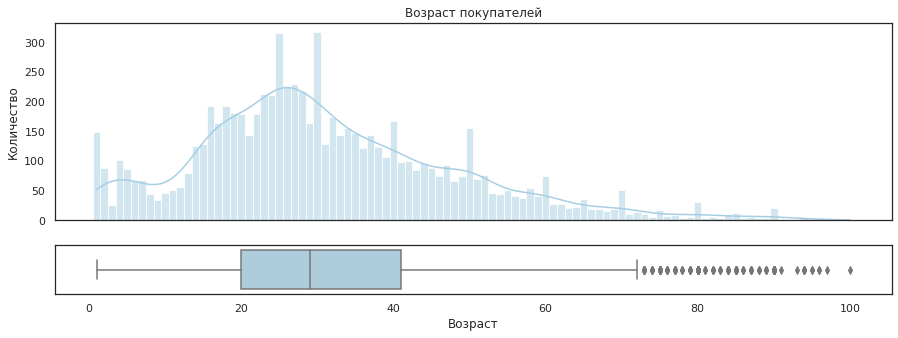

In [8]:
# гистограмма распределения возраста покупателей:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                      figsize=(15, 5), 
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[4,1]))

sns.histplot(data=labels,
             x='real_age',
             discrete=True,
             kde=True,
             ax=axs_hist)\
.set(title='Возраст покупателей', ylabel='Количество')

sns.boxplot(data=labels, x='real_age', ax=axs_box)\
.set(xlabel='Возраст');
plt.show()

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.1.2:**
    
    - Всего в датафрейме 7591 фотография
    - Средний возраст - 31 год, медианный - 29 лет
    - Основная часть покупателей в возрасте от 20 до 41 года (по квартилям 25% и 75%)
    - Минимальный и максимальный возраст: от 1 до 100 лет
    - На графике распределения возраста видны всплески на отметках: 25, 30, 40, 50, 60, 70, 80 и 90 лет. Вероятно, что при заполнении карточки данных, не на всех людей была информация о возрасте и тот, кто заполнял, поставил наиболее близкий возраст округляя дату до "круглой отметки"
    - Есть отдельные кластеры для ранних возрастов и позже - вероятно, фото этих кластеров составлялись из разных датасетов
    - Смещение вправо показывает на малое количество людей пожилого возраста. Возможно модель плохо обучится на этих возрастах       

### Выборка фотографий

Напечатаем на экране 12 фотографий, посмотрим, как устроен датасет

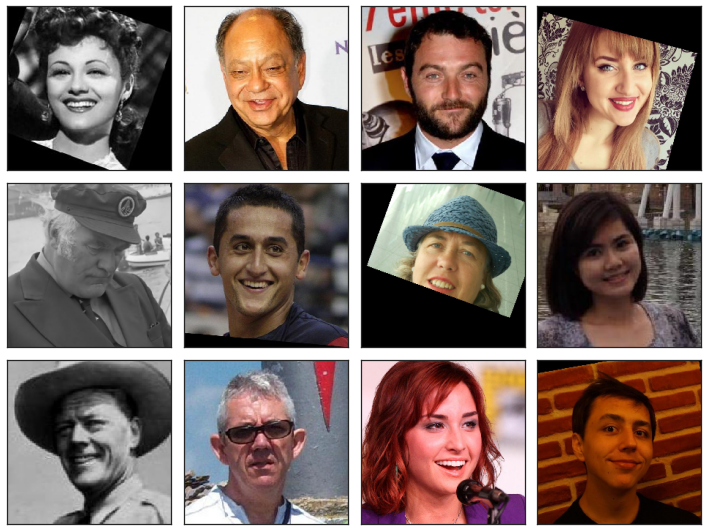

In [9]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.1.3:**
    
    - Фото все разные по: месту съемки, качеству камеры, ракурсу съемки, заднему плану, наклону к горизонту, освещенности и другим показателям
    - Состав людей очень разообразен: от младенцев до преклонного возраста
    - Настроение (эмоции) людей тоже разное: радость, грусть, безразличие, смех...
    - Разные предметы на фото: микрофон, пузырь от жвачки, кепка, наушники
    - Все эти факторы можно отнести к "жизненным ситуациям", которые могут возникнуть в том числе и в магазине. Так что модели ML придется потрудиться, чтобы хорошо распознавать возраст людей
    - Для модели важен контент на фото - например, старые фото могут сбивать качество модели, так как архитектуры со сверточными слоями обращают больше внимания на текстуру, а не на форму (подробнее: <a href="https://habr.com/ru/articles/591779/">ссылка</a>)
    - В датасете еще присутствует много искусственных поворотов для выравнивания лица

## Обучение модели

По фотографии нужно определить возраст человека, следовательно будем решать задачу **Регрессии**, т.е. число в ответе — это количество лет. Прогноз и верный ответ можно сравнить: чем дальше предсказание от реального ответа, тем оно хуже.

Работать будем с сетью ResNet50, предобученной на датасете ImageNet. В нём 1000 классов, нужен всего один нейрон, который вернёт число-предсказание.

В конце сети должен остаться только один нейрон. Для него сто́ит выбрать активацию **ReLU**, т.к. положительные прогнозы сети функция **ReLU** не меняет, а все отрицательные — приводит к нулю. Чисел меньше 0 быть не может.

В задаче допустимы функции потерь: **Mean Squared Error** (MSE) и **Mean Absolute Error** (MAE) - функции потерь для регрессии.


Нашей метрикой качества будет **MAE**.

<div style='border:solid green 3px; padding: 20px'>
    
**КОД ВЫПОЛНЕНИЯ МОДЕЛИ НА GPU**
    
```
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

RS = 55
BATCH_SIZE = 32

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        subset='training',
        seed=RS)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        subset='validation',
        seed=RS)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
    
```

<div style='border:solid green 3px; padding: 20px'>
    
**РЕЗУЛЬТАТ ВЫПОЛНЕНИЯ МОДЕЛИ НА GPU**

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >
    
Train for 178 steps, validate for 60 steps
Epoch 1/20
2023-08-09 08:59:52.402978: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-09 08:59:52.731768: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 58s - loss: 228.8640 - mae: 10.9260 - val_loss: 615.0745 - val_mae: 19.7816
Epoch 2/20
178/178 - 48s - loss: 77.8932 - mae: 6.6462 - val_loss: 705.4459 - val_mae: 21.5849
Epoch 3/20
178/178 - 47s - loss: 51.2480 - mae: 5.4393 - val_loss: 448.2988 - val_mae: 16.2886
Epoch 4/20
178/178 - 46s - loss: 36.2976 - mae: 4.6153 - val_loss: 116.8242 - val_mae: 8.3503
Epoch 5/20
178/178 - 46s - loss: 27.5638 - mae: 3.9911 - val_loss: 75.0846 - val_mae: 6.5390
Epoch 6/20
178/178 - 46s - loss: 24.1155 - mae: 3.7463 - val_loss: 70.9549 - val_mae: 6.2365
Epoch 7/20
178/178 - 48s - loss: 19.5754 - mae: 3.3835 - val_loss: 83.2670 - val_mae: 7.1856
Epoch 8/20
178/178 - 49s - loss: 16.2036 - mae: 3.0738 - val_loss: 64.8442 - val_mae: 6.0290
Epoch 9/20
178/178 - 48s - loss: 13.0112 - mae: 2.7667 - val_loss: 91.9554 - val_mae: 7.5813
Epoch 10/20
178/178 - 51s - loss: 11.3778 - mae: 2.5705 - val_loss: 70.4021 - val_mae: 6.2738
Epoch 11/20
178/178 - 51s - loss: 9.3334 - mae: 2.3284 - val_loss: 68.9437 - val_mae: 6.1427
Epoch 12/20
178/178 - 49s - loss: 8.9144 - mae: 2.2602 - val_loss: 82.3391 - val_mae: 6.7459
Epoch 13/20
178/178 - 46s - loss: 8.2816 - mae: 2.1912 - val_loss: 63.5222 - val_mae: 6.1038
Epoch 14/20
178/178 - 41s - loss: 7.4679 - mae: 2.0700 - val_loss: 61.6999 - val_mae: 5.8441
Epoch 15/20
178/178 - 38s - loss: 7.4428 - mae: 2.0700 - val_loss: 60.4713 - val_mae: 5.8776
Epoch 16/20
178/178 - 38s - loss: 7.4644 - mae: 2.0662 - val_loss: 61.7563 - val_mae: 5.8792
Epoch 17/20
178/178 - 38s - loss: 7.2496 - mae: 2.0417 - val_loss: 61.4594 - val_mae: 5.7869
Epoch 18/20
178/178 - 38s - loss: 7.0830 - mae: 2.0253 - val_loss: 63.5899 - val_mae: 6.0703
Epoch 19/20
178/178 - 37s - loss: 7.6191 - mae: 2.0659 - val_loss: 63.5159 - val_mae: 6.0552
Epoch 20/20
178/178 - 38s - loss: 6.8885 - mae: 1.9809 - val_loss: 62.5284 - val_mae: 5.9187
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 62.5284 - mae: 5.9187
Test MAE: 5.9187
```

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.2:**
    
   В [статье о датасете](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf), с которым мы работали, значение MAE равно 5.4 — у нас был получен результат **MAE = 5.92**, что является меньше 7 исходя из ТЗ

## Анализ обученной модели

<div style='border:solid violet 5px; padding: 20px'>

**ОБЩИЕ ВЫВОДЫ**

Исходная задача была построить и обучить модель, которя поможет определять возраст человека по изображению с камеры со средним абсолютным отклонением **MAE** не выше 7. Модель справилась достаточно хорошо,  результат составил **MAE = 5.92**.

Если использовать эту модель, то ее достаточно для анализа покупок с целью предложений товары, которые могут заинтересовать покупателей разной возрастной группы. Группы лучше разбивать с **шагом** не более **6 лет**, чтобы модель могла правильно распределять покупателей. Шаг групп в 10 лет может оказаться менее информативным для коммерческого и аналитического отдела, где изучают особенности покупок возрастных категорий.
    
Для бизнеса хуже, когда возрастные группы имеют шаг в 10 лет, чем шаг 5 лет. Так как модель имеет среднюю ошибку в определении возраста 6 лет, то в группы по 5 лет будет часто не попадать, в десятилетние группы будет попадать хорошо, но для бизнеса это менее интересно. Поэтому выбран баланс в 6 лет. При этом в случае групп имеет смысл посчитать ошибку модели для каждой группы отдельно, так как MAE 5.92 показывает среднюю ошибку на всем датасете, а наш датасет имеет дисбаланс возрастов - в разрезе групп ситуация может быть другой.